In [ ]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import numpy as np

# Load your data
training_data = pd.read_csv('TrainingDataset.csv')
testing_data = pd.read_csv('TestingDataSet.csv')

# Function to balance the dataset
def balance_dataset(X, y):
    df = pd.concat([X, y], axis=1)
    classes = df['Output'].unique()
    
    resampled_dfs = []
    for cls in classes:
        df_class = df[df['Output'] == cls]
        if not df_class.empty:
            max_count = max(df['Output'].value_counts())
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=123)
            resampled_dfs.append(df_class_resampled)
    
    if resampled_dfs:
        df_resampled = pd.concat(resampled_dfs)
        X_resampled = df_resampled.drop('Output', axis=1)
        y_resampled = df_resampled['Output']
        return X_resampled, y_resampled
    else:
        raise ValueError("No data found for balancing.")

# Function to preprocess data
def preprocess_data(data, scaler=None, is_train=True):
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]

    if is_train:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        X, y = balance_dataset(pd.DataFrame(X), y)
        # Save the scaler to a file
        scaler_filename = 'scaler.joblib'
        dump(scaler, scaler_filename)
    else:
        X = scaler.transform(X)
    
    return X, y, scaler

# Preprocess the training and testing data
X_train, y_train, scaler = preprocess_data(training_data)
X_test, y_test, _ = preprocess_data(testing_data, scaler, is_train=False)

# Define the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Piper longum', 'Piper betel', 'Piper nigrum']))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Save the trained model
model.save('trained_model.h5')

# Define a function to preprocess user input
def preprocess_user_input(input_data, scaler):
    # Convert the input data into a DataFrame
    input_df = pd.DataFrame([input_data], columns=['Leaf length(cm)', 'Leaf width(cm)', 'Stem diameter(cm)',
                                                   'Internode length(cm)', 'Leaf vein density(veins/cm²)',
                                                   'Number of leaves per node'])
    # Scale the input data using the loaded scaler
    input_scaled = scaler.transform(input_df)
    return input_scaled

# Load the trained model and scaler
model = load_model('trained_model.h5')
scaler = load('scaler.joblib')

# Get inputs from the user
input_data = {
    'Leaf length(cm)': float(input("Enter Leaf length(cm): ")),
    'Leaf width(cm)': float(input("Enter Leaf width(cm): ")),
    'Stem diameter(cm)': float(input("Enter Stem diameter(cm): ")),
    'Internode length(cm)': float(input("Enter Internode length(cm): ")),
    'Leaf vein density(veins/cm²)': float(input("Enter Leaf vein density(veins/cm²): ")),
    'Number of leaves per node': float(input("Enter Number of leaves per node: "))
}

# Preprocess the user inputs
input_scaled = preprocess_user_input(input_data, scaler)

# Make a prediction
prediction = model.predict(input_scaled)
predicted_class = prediction.argmax(axis=1)[0]

# Map the predicted class to the tree name
tree_names = ['Piper longum', 'Piper betel', 'Piper nigrum']
predicted_tree_name = tree_names[predicted_class]

# Print the predicted tree name
print(f'The predicted tree name is: {predicted_tree_name}')


Epoch 1/50
11/11 [==============================] - 1s 35ms/step - loss: 0.9400 - accuracy: 0.7738 - val_loss: 0.9446 - val_accuracy: 0.7381
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6552 - accuracy: 0.9583 - val_loss: 0.8108 - val_accuracy: 0.7381
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.4551 - accuracy: 0.9702 - val_loss: 0.7114 - val_accuracy: 0.8095
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.9821 - val_loss: 0.5747 - val_accuracy: 1.0000
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2117 - accuracy: 0.9940 - val_loss: 0.4424 - val_accuracy: 1.0000
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.1455 - accuracy: 1.0000 - val_loss: 0.3232 - val_accuracy: 1.0000
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1004 - accuracy: 1.0000 - val_loss: 0.2274 - val_accuracy: 1.0000
Epoch 8/50
11/11 [=

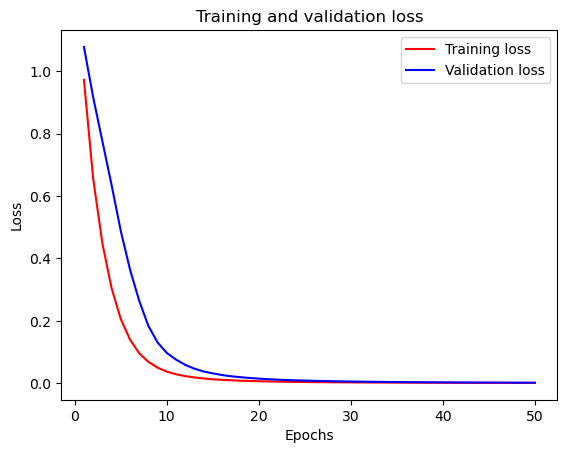

In [4]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

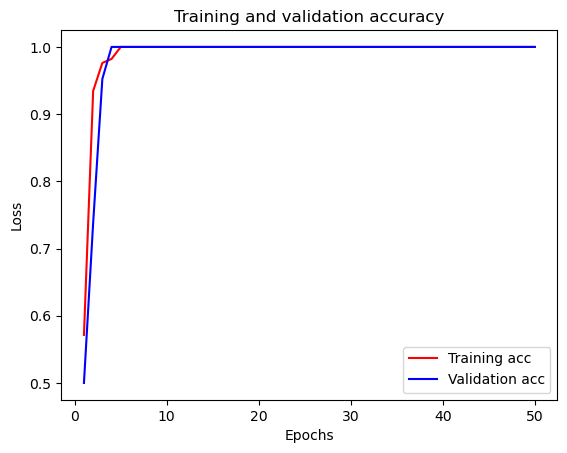

In [5]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()